In [1]:
# =============================================================================
# 1. Libraries
# =============================================================================
# General purpose
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
from collections import Counter
import re
import warnings
import itertools
pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Clustering and networks
import igraph
import networkx as nx
from networkx.algorithms import community
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from community import community_louvain
from kmodes.kmodes import KModes

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

# Confidence interval
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return np.round(m, 2), np.round(m-h), np.round(m+h, 2)


# Colors
COLORS_SET_B_G_R = [sns.color_palette('muted')[0], sns.color_palette('muted')[2], sns.color_palette('muted')[3]]

In [2]:
# Load survey data
survey_schema = pd.read_csv('/kaggle/input/kaggle-survey-2019/survey_schema.csv')
df_responses = pd.read_csv('/kaggle/input/kaggle-survey-2019/multiple_choice_responses.csv')

# Dataframe with question code and description
qs = df_responses.iloc[0].T.to_frame()
qs.index.name = "name"
qs.columns = ["description"]

# Remove question labels from the dataset
df_responses.drop(0, inplace=True)
df_responses.reset_index(inplace=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (0,3,7,19,34,47,49,50,51,52,53,54,68,81,94,96,109,115,130,139,147,154,167,180,193,206,219,232,245) have mixed types. Specify dtype option on import or set low_memory=False.



# <a>Deep Dive into Science: Exploring PhD Community with Network Analysis</a>
*This notebook was prepared by Ekaterina Melianova and Artem Volgin*

![](https://policyoptions.irpp.org/wp-content/uploads/sites/2/2019/08/Twitter-End-the-PhD-bashing-to-end-the-PhD-problem.jpg)
The image was taken from [this article](https://policyoptions.irpp.org/magazines/august-2019/end-the-phd-bashing-to-end-the-phd-problem/) 

# <a>Introduction</a>

Many of us have ever thought of pursuing an academic career and gaining a doctoral degree. This is not surprising given an amplified need for highly trained and qualified employees in data science and experts in AI. PhD programs allow to conceivably enrich the existing corpus of knowledge and upgrade one’s skillset in a structured and systematic manner, which seems notoriously hard to do elsewhere. Amongst other things, the PhD achievement is an entry to an academic elite. However, lots of doctoral AI specialists may not get a chance to enjoy the benefits of their expertise [1].

One reason is that in recent years, the importance of a PhD degree in data science has been questioned due to a stark growth in the number of doctoral degree graduates involved in labor markets outside the university, bringing about the question of PhD training relevance. Past empirical evidence suggests that doctoral education may contribute to overeducation and credential inflation [2]. Another striking indicator of a PhD’s seeming value loss is a drop in the share of chief executives with doctorates coupled with PhD holders’ income fall [3].

Furthermore, these days, there are fewer incentives to complete a lengthy PhD program, and not everyone succeeds. People strive to occupy a job position in the industry, which does not require a doctoral degree and can be more lucrative than the research work not requesting a PhD level. The area of data science and software engineering is one of the most vulnerable in that respect: universities are lagging far behind their practice-oriented counterparts in terms of knowledge generation. Therefore, the qualification of doctorates in AI might seem dated or too specific at the applied space.


In [3]:
# Create dataframe for visualization of Q4
Q4_distrib = pd.DataFrame(df_responses['Q4'].value_counts())
Q4_distrib.reset_index(inplace=True)
Q4_distrib_grey = Q4_distrib.copy() 
Q4_distrib_grey = Q4_distrib_grey.replace(to_replace=2767, value=0)

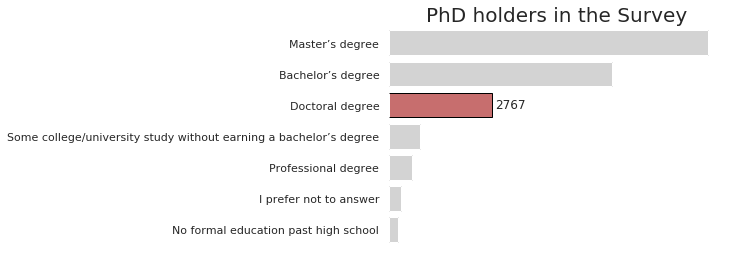

In [4]:
# Visualization of Q4
sns.set(style="whitegrid")
f,ax = plt.subplots(figsize=(6, 4))

# Plot first layer
sns.barplot(x="Q4", y="index", data=Q4_distrib,
            color=COLORS_SET_B_G_R[2], edgecolor='black')
sns.despine(left=True, bottom=True)

# Plot second layer
sns.set(style="whitegrid")
sns.barplot(x="Q4", y="index", data=Q4_distrib_grey,
            color='lightgrey')
sns.despine(left=True, bottom=True)

# Add number of PhD holders
_ = plt.text(2850, 2.1, '2767', fontsize=12)

# Set title
_ = ax.set_title('PhD holders in the Survey', fontsize=20)

# Remove redundant labels and borders
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

# Options setup
_ = plt.setp(f.patches, linewidth=0.5) 

Given this context, several critical research questions come to the fore. 
* *What are the skillset types that describe a PhD person?*
* *Are there signs of a skillset erosion in the data science field among doctorates?*
* *How does the skill-related environment of PhD holders in data science differ between nations?*
* *What are the core and the periphery skills for doctorates overall and across regional communities?*
* *Do people in the data science field earn more with a PhD status?* 
* *Does gender discrimination also apply to women with a PhD degree? *
* *Finally, is a PhD degree really worth it in the data science area?*

The current project unfolds a coherent story that attempts to answer these questions using 2019 Kaggle ML & DS Survey data. Importantly, all the inferences that are stated in this notebook can describe only Kaggle users and should not be extrapolated to the broader population of data analysts.

The study leverages potent techniques of **Network Analysis** which has become exceptionally frequent in a growing body of multidisciplinary research.


In [5]:
# Create subsets of variable dedicated to skills, activities, programming languages etc.
ide_usage = ["Q16_Part_1", "Q16_Part_2", "Q16_Part_3", "Q16_Part_4", "Q16_Part_5", "Q16_Part_6", "Q16_Part_7", "Q16_Part_8", "Q16_Part_9", "Q16_Part_10"]
notebook_usage = ["Q17_Part_1", "Q17_Part_2", "Q17_Part_3", "Q17_Part_4", "Q17_Part_5", "Q17_Part_6", "Q17_Part_7", "Q17_Part_8", "Q17_Part_9", "Q17_Part_10"]
language_usage = ["Q18_Part_1", "Q18_Part_2", "Q18_Part_3", "Q18_Part_4", "Q18_Part_5", "Q18_Part_6", "Q18_Part_7", "Q18_Part_8", "Q18_Part_9", "Q18_Part_10"]
visual_usage = ["Q20_Part_1", "Q20_Part_2", "Q20_Part_3", "Q20_Part_4", "Q20_Part_5", "Q20_Part_6", "Q20_Part_7", "Q20_Part_8", "Q20_Part_9", "Q20_Part_10"]
algo_usage = ["Q24_Part_1", "Q24_Part_2", "Q24_Part_3", "Q24_Part_4", "Q24_Part_5", "Q24_Part_6", "Q24_Part_7", "Q24_Part_8", "Q24_Part_9", "Q24_Part_10"]
ml_tools_usage = ["Q25_Part_1", "Q25_Part_2", "Q25_Part_3", "Q25_Part_4", "Q25_Part_5", "Q25_Part_6"]
cv_usage = ["Q26_Part_1", "Q26_Part_2", "Q26_Part_3", "Q26_Part_4", "Q26_Part_5"]
nlp_usage = ["Q27_Part_1", "Q27_Part_2", "Q27_Part_3", "Q27_Part_4"]
ml_frameworks_usage = ["Q28_Part_1", "Q28_Part_2", "Q28_Part_3", "Q28_Part_4", "Q28_Part_5", "Q28_Part_6", "Q28_Part_7", "Q28_Part_8", "Q28_Part_9", "Q28_Part_10"]
cloud_platforms_usage = ["Q29_Part_1", "Q29_Part_2", "Q29_Part_3", "Q29_Part_4", "Q29_Part_5", "Q29_Part_6", "Q29_Part_7", "Q29_Part_8", "Q29_Part_9", "Q29_Part_10"]
cloud_products_usage = ["Q30_Part_1", "Q30_Part_2", "Q30_Part_3", "Q30_Part_4", "Q30_Part_5", "Q30_Part_6", "Q30_Part_7", "Q30_Part_8", "Q30_Part_9", "Q30_Part_10"]
big_data_products_usage = ["Q31_Part_1", "Q31_Part_2", "Q31_Part_3", "Q31_Part_4", "Q31_Part_5", "Q31_Part_6", "Q31_Part_7", "Q31_Part_8", "Q31_Part_9", "Q31_Part_10"]
ml_products_usage = ["Q32_Part_1", "Q32_Part_2", "Q32_Part_3", "Q32_Part_4", "Q32_Part_5", "Q32_Part_6", "Q32_Part_7", "Q32_Part_8", "Q32_Part_9", "Q32_Part_10"]
automl_tools = ["Q33_Part_1", "Q33_Part_2", "Q33_Part_3", "Q33_Part_4", "Q33_Part_5", "Q33_Part_6", "Q33_Part_7", "Q33_Part_8", "Q33_Part_9", "Q33_Part_10"]
db_tools = ["Q34_Part_1", "Q34_Part_2", "Q34_Part_3", "Q34_Part_4", "Q34_Part_5", "Q34_Part_6", "Q34_Part_7", "Q34_Part_8", "Q34_Part_9", "Q34_Part_10"]

# Get separate dataframe with skills related questions
skills_questions = [ide_usage, notebook_usage, language_usage, visual_usage, algo_usage,
                    ml_tools_usage, cv_usage, nlp_usage, ml_frameworks_usage, cloud_platforms_usage, big_data_products_usage,
                   ml_products_usage, automl_tools, db_tools]
skills_questions = np.concatenate(skills_questions)
df_skills = df_responses[skills_questions]

# Recode to binary
df_skills[~df_skills.isnull()] = 1
df_skills[df_skills.isnull()] = 0

# Remove participant who did not mentioned any skills
df_skills = df_skills[df_skills.sum(1) > 0]

# Get proper labels for skills
labels = pd.DataFrame(df_skills.columns).merge(qs, left_on='name', right_on='name')
# Preprocess lables
labels['description'] = labels['description'].apply(lambda string: string.strip())
def fixMatlab(string):
    if 'MATLAB' in string:
        if 'IDE' in string:
            string = string + ' IDE'
        else:
            string = string + ' language'
    return string
labels['description'] = labels['description'].apply(fixMatlab)
labels['description'] = labels['description'].apply(
    lambda d: re.sub("[\(\[].*?[\)\]]", "", d.split('Selected Choice - ')[-1]).strip())
df_skills.columns = labels['description']

# Remove rare skills
SELECTED_SKILLS = df_skills.sum(0).sort_values(ascending=False)[df_skills.sum(0) > 500].index
df_skills = df_skills.loc[:,SELECTED_SKILLS]
# Remove participant who did not mentioned any skills
df_skills = df_skills[df_skills.sum(1) > 0]

# Create final dataframe with socio-demographic parameters and skills
df_socdem = df_responses.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q10', 'Q15', 'Q23']]
df_fin = df_socdem.merge(df_skills, left_index=True, right_index=True)

# Change names of countries
df_fin['Q3'] = df_fin['Q3'].replace({'Iran, Islamic Republic of...':'Iran',
                                     'Republic of Korea':'South Korea',
                                     'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                                     'United States of America':'USA'})

# Drop respondents who did't indicate their country
df_fin = df_fin.dropna(subset=['Q3'])

# PhD or Not PhD
df_fin['Q4_phd'] = list(map(lambda e: 'PhD' if e == 'Doctoral degree' else 'not PhD', df_fin['Q4']))
df_fin['Q4_phd'] = df_fin['Q4_phd'].astype('category')

# Student or Not Student
df_fin['student'] = ['Student' if p == 'Student' else 'Not Student' for p in df_fin['Q5']]
df_fin['student'] = df_fin['student'].astype('category')

# Salary to ordinal
df_fin['Q10'] = df_fin['Q10'].astype('category')
df_fin['Q10'].cat.reorder_categories(["$0-999", "1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999",
                                      "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999",
                                      "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999",
                                      "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999",
                                      "90,000-99,999", "100,000-124,999", "125,000-149,999", "150,000-199,999",
                                      "200,000-249,999", "250,000-299,999", "300,000-500,000", "> $500,000"]
                                      , inplace=True)

# Experience to ordinal
df_fin['Q15'] = df_fin['Q15'].astype('category')
df_fin['Q15'].cat.reorder_categories(['< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']
                                      , inplace=True)

# Age to ordinal
df_fin['Q1'] = df_fin['Q1'].astype('category')
df_fin['Q1'].cat.reorder_categories(['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70+'], inplace=True)

# Varible with Top 20 countries
top_countries = list(df_fin.Q3.value_counts().head(21).index)
top_countries.remove('Other')
df_fin['Q3_top'] = list(map(lambda c: c if c in top_countries else np.nan, df_fin['Q3']))

# <a>General Socio-Demographic Portrait of a PhD Kaggler</a>

To give an overall understanding of who PhD holders, working in the field of data science and Al, are, we first start with their socio-demographic description.

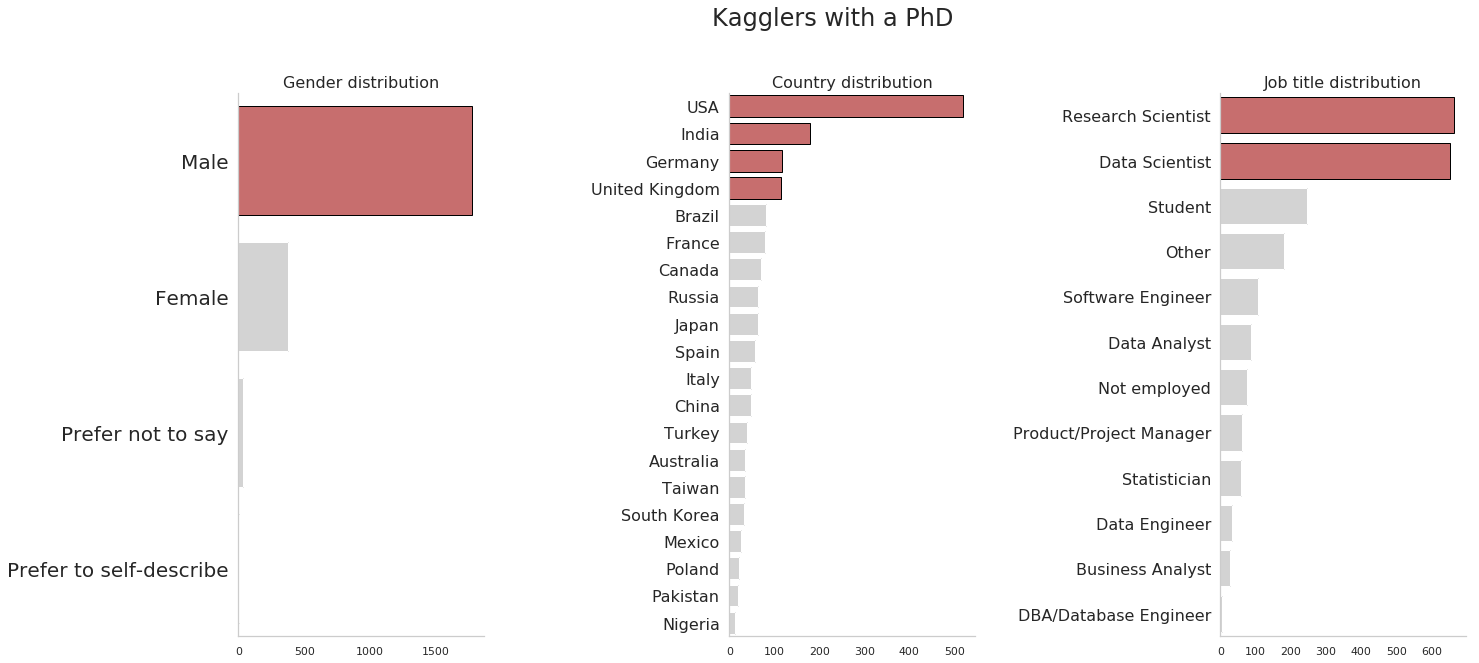

In [6]:
# Create dataframe for visualization of Q4
df_phd_viz = df_fin[df_fin['Q4_phd'] == 'PhD']
df_phd_viz_country = pd.DataFrame(df_phd_viz['Q3_top'].value_counts())
df_phd_viz_country.reset_index(inplace=True)
df_phd_viz_country_grey = df_phd_viz_country.copy()
df_phd_viz_country_grey['Q3_top'] = [0] * 4 + list(df_phd_viz_country_grey['Q3_top'])[4:]

# Create dataframe for visualization of Q5
df_phd_viz_role = pd.DataFrame(df_phd_viz['Q5'].value_counts())
df_phd_viz_role.reset_index(inplace=True)
df_phd_viz_role_grey = df_phd_viz_role.copy()
df_phd_viz_role_grey['Q5'] = [0] * 2 + list(df_phd_viz_role_grey['Q5'])[2:]

# Create dataframe for visualization of Q2
df_phd_viz_gender = pd.DataFrame(df_phd_viz['Q2'].value_counts())
df_phd_viz_gender.reset_index(inplace=True)
df_phd_viz_gender_grey = df_phd_viz_gender.copy()
df_phd_viz_gender_grey['Q2'] = [0] + list(df_phd_viz_gender_grey['Q2'])[1:]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 10))
# Plot first layer
sns.barplot(x="Q2", y="index", data=df_phd_viz_gender,
            label="Total",ax=axes[0], color=COLORS_SET_B_G_R[2], edgecolor='black')
# Plot second layer
sns.barplot(x="Q2", y="index", data=df_phd_viz_gender_grey,
            label="Total",ax=axes[0], color='lightgrey')

# Remove redundant labels and borders
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")

# Set title
_ = axes[0].set_title('Gender distribution', fontsize=16)

# Set xticks labels
axes[0].tick_params(axis='y', which='major', labelsize=20)

# Plot first layer
sns.barplot(x="Q3_top", y="index", data=df_phd_viz_country,
            label="Total", ax=axes[1], color=COLORS_SET_B_G_R[2], edgecolor='black')
# Plot second layer
sns.barplot(x="Q3_top", y="index", data=df_phd_viz_country_grey,
            label="Total",ax=axes[1], color='lightgrey')
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
_ = axes[1].set_title('Country distribution', fontsize=16)
axes[1].tick_params(axis='y', which='major', labelsize=16)

# Plot first layer
sns.barplot(x="Q5", y="index", data=df_phd_viz_role,
            label="Total", ax=axes[2], color=COLORS_SET_B_G_R[2], edgecolor='black')
# Plot second layer
sns.barplot(x="Q5", y="index", data=df_phd_viz_role_grey,
            label="Total",ax=axes[2], color='lightgrey')
axes[2].xaxis.grid(False)
axes[2].yaxis.grid(False)
axes[2].xaxis.set_label_text("")
axes[2].yaxis.set_label_text("")
_ = axes[2].set_title('Job title distribution', fontsize=16)
axes[2].tick_params(axis='y', which='major', labelsize=16)
sns.despine(left=False, bottom=False)

# Add title
st = fig.suptitle("Kagglers with a PhD", fontsize=24, x =0.5, y=1)

# Additional setup
fig.subplots_adjust(wspace=1)
_ = plt.setp(fig.patches, linewidth=0.5)

Graphs above show that the number of males with PhD achievement is roughly 5 times as high as women, meaning that even a highly academic environment retains this drastically pronounced gender-related disproportion. 
 
In absolute terms, the US tangibly outperforms other countries by the amount PhD specialists released. The second place is occupied by India, followed by Germany and the UK that are on a comparable level.
 
Research scientists and data scientists are the most frequent job titles among doctoral holders. The sample also includes 246 PhD students who have not received their degree yet.

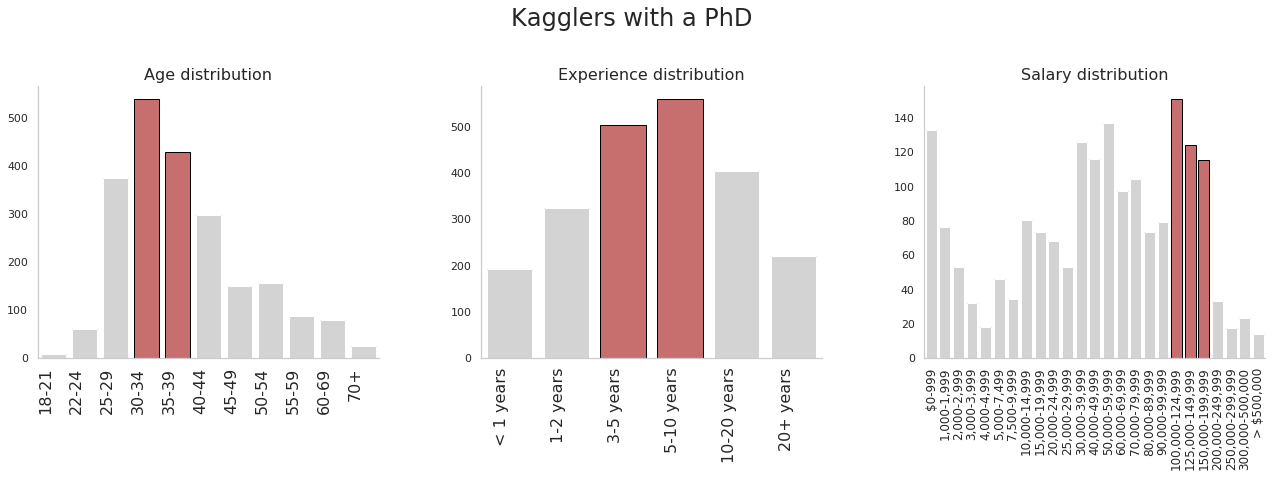

In [7]:
# Create dataframe for visualization of Q1
df_phd_viz_age = df_phd_viz.copy()
df_phd_viz_age = df_phd_viz_age.query("Q1 != '30-34' and Q1 != '35-39'")

# Create dataframe for visualization of Q15
df_phd_viz_exp = df_phd_viz.copy()
df_phd_viz_exp = df_phd_viz_exp.query("Q15 != '3-5 years' and Q15 != '5-10 years'")

# Create dataframe for visualization of Q10
df_phd_viz_salary = df_phd_viz.copy()
df_phd_viz_salary = df_phd_viz_salary.query("Q10 != '100,000-124,999' and Q10 != '125,000-149,999' and Q10 != '150,000-199,999'")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
# Plot first layer
g = sns.countplot(x="Q1", color=COLORS_SET_B_G_R[2], data=df_phd_viz, ax=axes[0], edgecolor='black')
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
# Plot second layer
g = sns.countplot(x="Q1", color="lightgrey", data=df_phd_viz_age, ax=axes[0])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
_ = axes[0].set_title('Age distribution', fontsize=16)
axes[0].tick_params(axis='x', which='major', labelsize=16)

# Plot first layer
g = sns.countplot(x="Q15", color=COLORS_SET_B_G_R[2], data=df_phd_viz, ax=axes[1], edgecolor='black')
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
# Plot second layer
g = sns.countplot(x="Q15", color="lightgrey", data=df_phd_viz_exp, ax=axes[1])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
_ = axes[1].set_title('Experience distribution', fontsize=16)
axes[1].tick_params(axis='x', which='major', labelsize=16)

# Plot first layer
g = sns.countplot(x="Q10", color=COLORS_SET_B_G_R[2], data=df_phd_viz, ax=axes[2], edgecolor='black')
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)
# Plot second layer
g = sns.countplot(x="Q10", color="lightgrey", data=df_phd_viz_salary, ax=axes[2])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)
axes[2].xaxis.grid(False)
axes[2].yaxis.grid(False)
axes[2].xaxis.set_label_text("")
axes[2].yaxis.set_label_text("")
_ = axes[2].set_title('Salary distribution', fontsize=16)
axes[2].tick_params(axis='x', which='major', labelsize=12)

# Add title
st = fig.suptitle("Kagglers with a PhD", fontsize=24, x =0.5, y=1.1)

# Additional setup
sns.despine(left=False, bottom=False)
fig.subplots_adjust(wspace=0.3)
_ = plt.setp(fig.patches, linewidth=0.5)

People with a doctoral degree are mostly older than 30. As for the data science experience, Kagglers with PhD on average have worked for 3-10 years.
 
Salaries of doctorates vary substantially, nevertheless are quite high in general. The observed variation might be caused by differences in average wage levels across nations, but this issue will be further discussed more thoroughly.

# <a>What are the Skillset Types that Describe a PhD Kaggler? Specialization or Erosion of Boundaries?</a>
The traditional statistics rely on premises that observations in the data are independent. However, this is rarely the case in a real social world where people are dependent with regard to a variety of characteristics. Network Analysis is a field in statistics that intentionally erects and comprehensively models those connections. Friendship network in social media is one of the most widespread examples of how social dependencies can be represented. 

In the current analysis, we take a step further and build a network of PhD holders based on the similarity of their **skillsets – binary variables, reflecting the possession of a particular skill or the presence of proficiency in software**. The following questions were used to compute the skillset similarity (skills that appeared less than 500 times in the sample were excluded from the analysis):

* *Q16: Which of the following integrated development environments (IDE's) do you use on a regular basis?*
* *Q17: Which of the following hosted notebook products do you use on a regular basis?*
* *Q18: What programming languages do you use on a regular basis?*
* *Q20: What data visualization libraries or tools do you use on a regular basis?*
* *Q24: Which of the following ML algorithms do you use on a regular basis?*
* *Q25: Which categories of ML tools do you use on a regular basis?*
* *Q26: Which categories of computer vision methods do you use on a regular basis?*
* *Q27: Which of the following natural language processing (NLP) methods do you use on a regular basis?*
* *Q28: Which of the following machine learning frameworks do you use on a regular basis?*
* *Q29: Which of the following cloud computing platforms do you use on a regular basis?*
* *Q30: Which specific cloud computing products do you use on a regular basis?*
* *Q31: Which specific big data / analytics products do you use on a regular basis?*
* *Q32: Which of the following machine learning products do you use on a regular basis?*
* *Q33: Which automated machine learning tools (or partial AutoML tools) do you use on a regular basis?*
* *Q34: Which of the following relational database products do you use on a regular basis?*

To model network connections such metric as cosine similarity was leveraged: we formed a tie between a pair of nodes if the respective value of cosine similarity was above the 99th quantile of its distribution. To our best knowledge, this is the first attempt to approach the issue of relationship representation in such a manner.

In [8]:
def participantsGraphObj(df, q_threshold=0.95, SELECTED_SKILLS=SELECTED_SKILLS, only_phd=True, removeDisconnected=True):
    
    # Select only PhD participants
    if only_phd:
        df = df.query("Q4 == 'Doctoral degree'")
    df.reset_index(inplace=True, drop=True)
    # Create similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS])
    threshold = np.quantile(np.concatenate(similarity_matrix), q_threshold)
    # threshold = np.median(np.concatenate(similarity_matrix))
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    np.fill_diagonal(similarity_matrix, 0)
    # Create Graph structure
    G = igraph.Graph.Adjacency((similarity_matrix > 0).tolist())
    G.to_undirected()
    G.simplify()
    # Add vertex objects and connected indicator to intial dataframe
    df['vertex'] = list(G.vs)
    df['connected'] = pd.Series(G.components().membership) == 0
    if removeDisconnected:
        df = df[df['connected'] == True]
        G = G.induced_subgraph(list(df['vertex']))
        
    return df, G, similarity_matrix

df_phd, G, similarity_matrix = participantsGraphObj(df_fin, q_threshold=0.99)

# Community detection
fg = G.community_fastgreedy()
fg = fg.as_clustering()

# Add community label to the dataframe
df_phd['community'] = fg.membership

# Select only large communities
df_phd['community'] = [com if com <= 2  else np.nan for com in df_phd['community']]

# Creating layout
layout = G.layout("lgl")

# Rename communities according to the skills of participants
community_name_dict = {0:'Python and Deep Learning', 1:'R and Classical ML', 2:'Python and Classical ML'}
df_phd['community'] = df_phd['community'].map(community_name_dict)
df_phd['community'] = df_phd['community'].astype('category')

# Recode degree to binary
degree_list = list(G.degree())
modifed_degree_list = list(map(lambda x: 10 if x >= np.quantile(degree_list, 0.95) else 5, degree_list))
df_phd['degree'] = list(G.degree())
G.vs['size'] = modifed_degree_list

# Get appropriate colors for communities
community_colors = pd.Series(fg.membership).map({0:COLORS_SET_B_G_R[0],
                                                 1:COLORS_SET_B_G_R[1],
                                                 2:COLORS_SET_B_G_R[2]})
community_colors = list(community_colors.fillna('lightgrey'))

# To plot the bellow Graph without Text you need to execute following line:
# igraph.plot(G, layout=layout, edge_width=0.2, vertex_frame_width=0.5, vertex_color=community_colors, bbox=(800, 800))

# igraph doesnt support addition of titles or legend

![](https://i.imgur.com/NUXaMYi.jpg)

The above picture shows how the network of Kaggle doctoral graduates looks like. Colors depict homogeneous groups of AI professionals with PhD derived on the basis of network links determined. In the Network Analysis, this is termed as a community detection technique, which is somewhat similar to a traditional clustering procedure, except for complex relational parameters that the latter does not allow to capture and visualize.

Overall, we were able to find 3 robust communities: **R and Classical ML, Python and Classical ML,** and **Python and Deep Learning**. These titles vividly express the specificity of PhD holders that fell in the respective category; the wordclouds below demonstrate skills that are most attributable to each group. 


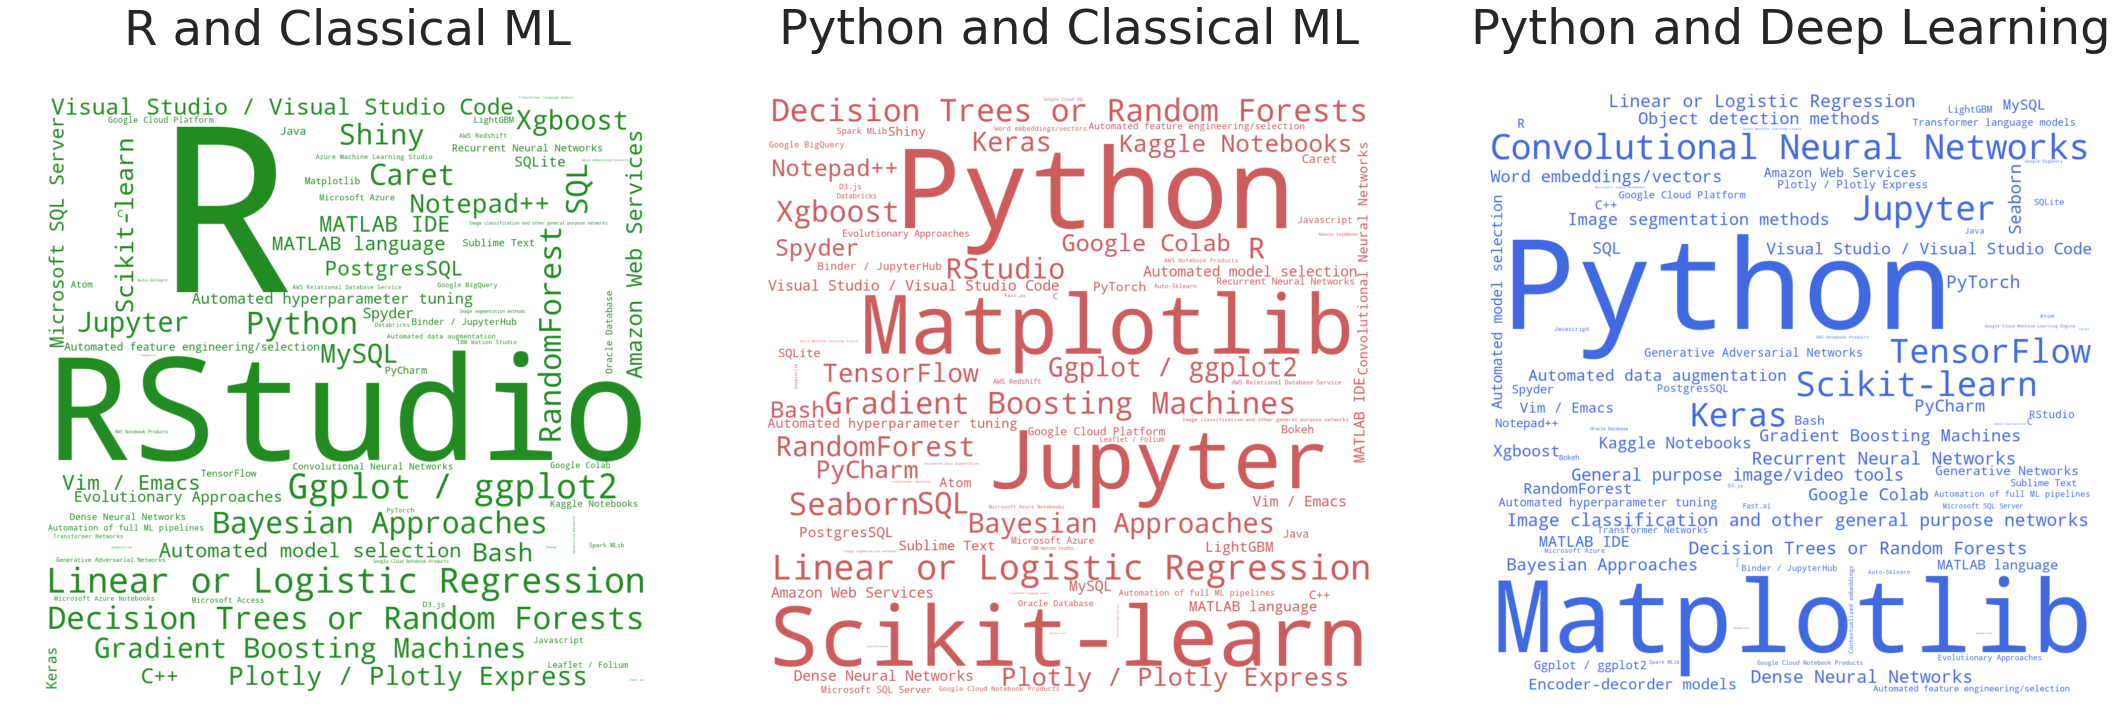

In [9]:
# Skills in each community
community_skills = pd.DataFrame({'R and Classical ML':df_phd[df_phd['community'] == 'R and Classical ML'].loc[:,SELECTED_SKILLS].sum(),
                                 'Python and Classical ML':df_phd[df_phd['community'] == 'Python and Classical ML'].loc[:,SELECTED_SKILLS].sum(),
                                 'Python and Deep Learning':df_phd[df_phd['community'] == 'Python and Deep Learning'].loc[:,SELECTED_SKILLS].sum()})

fig = plt.figure()
fig.set_size_inches(30, 10)

# Set of colors
colors_set = ['forestgreen', 'indianred', 'royalblue']
for i in range(community_skills.shape[1]):
    
    # Generate string with proportional words 
    top_skills = community_skills[community_skills.columns[i]].sort_values(ascending=True)
    top_skills = top_skills.rank()
    skills_string = []
    for skill_i in range(len(top_skills)):
        skills_string.extend([top_skills.index[skill_i]] * int(top_skills.values[skill_i]))
    ax = fig.add_subplot(1,3,i+1)
    word_could_dict=Counter(skills_string)
    # Create wordcloud object
    wordcloud = WordCloud(width = 1200, height = 1200, background_color="white",
                          color_func=lambda *args, **kwargs: colors_set[i], relative_scaling = 1).generate_from_frequencies(word_could_dict)
    

    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(community_skills.columns[i], size=48, pad=50)
    
plt.tight_layout(pad=0)
plt.show()

The next intriguing observation here refers to the proportion of students in the uncovered communities (see the left panel of the graph below): the upcoming generation of doctorates tends to utilize Python and Deep Learning tools to a greater extent compared to R and Classical statistical instruments. This is essential to know since it is people from the younger and higher educated generation who are usually considered trendsetters.

A unique opportunity that the network-based statistics offers is related to the analysis of centrality measures. In this mini-research, we focus on the degree centrality, which shows a number of ties a certain node has. The right panel of the graph below demonstrates how our **degree centrality, representing the extent of the skill-based similarity between people**, is manifested within the clusters on average (upper bounds of the colored boxes reflect mean degree values with a 95% confidence interval). An important inference here is that representatives of the “Python and Classical ML” cluster are much more similar to other PhD holders (the degree is large). This signifies the erosion of boundaries in a skillset that identifies this community, whereas 2 other clusters seem to be more specific in their professional capabilities.

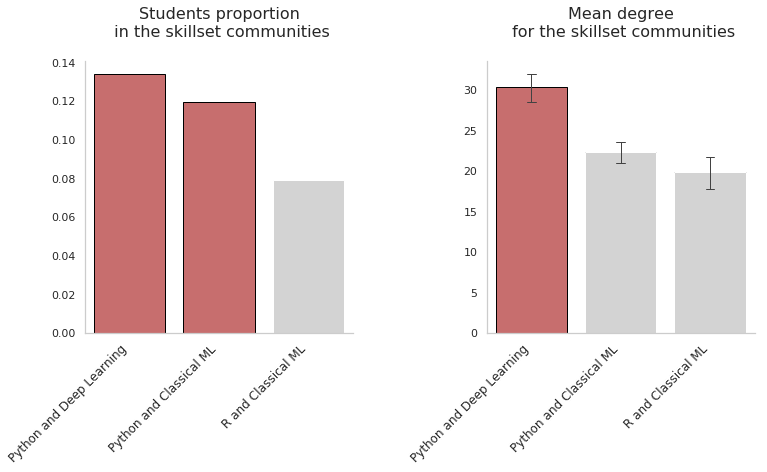

In [10]:
# Create dataframe for visualization
communties_students = pd.crosstab(df_phd['community'], df_phd['student'], normalize='index')
communties_students = pd.DataFrame(communties_students['Student'].sort_values(ascending=False))
communties_students.reset_index(inplace=True)
communties_students['community'] = communties_students['community'].astype('category')
communties_students['community'].cat.reorder_categories(['Python and Deep Learning', 'Python and Classical ML', 'R and Classical ML']
                                      , inplace=True)
communties_students_viz = communties_students.copy()
communties_students_viz['Student'] = list(communties_students_viz['Student'])[:2] + [0]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.set(style="whitegrid")
# First layer
sns.barplot(x="community", y="Student", data=communties_students,
            label="Total", color='lightgrey', ax=axes[0])
# Second layer
sns.barplot(x="community", y="Student", data=communties_students_viz,
            label="Total", color=COLORS_SET_B_G_R[2], ax=axes[0], edgecolor='black')

# Remove redundant borders
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Students proportion\n in the skillset communities', fontsize=16, pad=25)
# Set x ticks
axes[0].tick_params(axis='x', which='major', labelsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Create dataframe for visualization
df_phd_viz_degree_com = df_phd.copy()
df_phd_viz_degree_com = df_phd_viz_degree_com.query("community != 'Python and Classical ML'")
# First layer
g = sns.barplot(x="community", y="degree",
                data=df_phd, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, errwidth =1, ax=axes[1], edgecolor='black')
# Second layer
g = sns.barplot(x="community", y="degree",
                data=df_phd_viz_degree_com, color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[1])
# Remove redundant borders
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
sns.despine(left=False, bottom=False)
# Set tile
_ = axes[1].set_title('Mean degree\n for the skillset communities', fontsize=16, pad=25)
axes[1].tick_params(axis='x', which='major', labelsize=12)
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Additional options
fig.subplots_adjust(wspace=0.5)
_ = plt.setp(fig.patches, linewidth=0.5)

Two additional degree-related tables are curious. An inverse U-shaped pattern with the experience variable informs us that as experience goes up, PhD holders incrementally broaden the scope of skills that they have until they reach some middle point of around 3-5 years. This is then followed by the growth in a skillset “uniqueness” as PhD people become more experienced. 

Degree centrality allocated between PhD students and non-students poses evidence that students are more dispersed in their data science competencies. Graduating from a PhD program narrows down a skillset held, leading to a sharpening of one’s specialization.

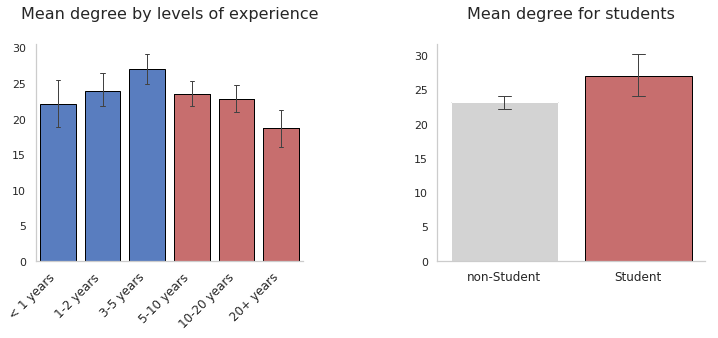

In [11]:
# Create dataframes for visualization
df_phd_viz_degree_exp = df_phd.copy()
df_phd_viz_degree_exp = df_phd_viz_degree_exp.query("Q15 != '< 1 years' and Q15 != '1-2 years' and Q15 != '3-5 years'")
df_phd_viz_degree_student = df_phd.copy()
df_phd_viz_degree_student = df_phd_viz_degree_student.query("student != 'Student'")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.set(font_scale=1, style="whitegrid")

# First layer
g = sns.barplot(x="Q15", y="degree",
                data=df_phd, color=COLORS_SET_B_G_R[0],
                dodge=True, ci=90, capsize=0.1, ax=axes[0], errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="Q15", y="degree",
                data=df_phd_viz_degree_exp, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=None, capsize=0.1, ax=axes[0], edgecolor='black')
# Remove redundant labels and borders
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
sns.despine(left=False, bottom=False)
# Set title
_ = axes[0].set_title('Mean degree by levels of experience', fontsize=16, pad=25)
# Set x ticks
axes[0].tick_params(axis='x', which='major', labelsize=12)

g = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

# First layer
g = sns.barplot(x="student", y="degree",
                data=df_phd, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, ax=axes[1], errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="student", y="degree",
                data=df_phd_viz_degree_student, color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[1])
# Remove redundant labels and borders
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
sns.despine(left=False, bottom=False)
# Set title
_ = axes[1].set_title('Mean degree for students', fontsize=16, pad=25)
# Set x ticks params
axes[1].tick_params(axis='x', which='major', labelsize=12)
_ = axes[1].xaxis.set_ticklabels(["non-Student", "Student"])

# Additional options
fig.subplots_adjust(wspace=0.5)
_ = plt.setp(fig.patches, linewidth=0.5)

# <a>How Does the Skill-Related Environment of Kaggle PhD Holders in Data Science Differ Between Nations?</a>

From a micro-level perspective on Kaggle PhD guys, we proceed to a global view remaining within a network-oriented paradigm.

The links in the network below depict a measure that was obtained by averaging the skill similarity on a respondent level for each country (we selected only well-represented countries). The connection was constructed if the skill similarity between the two countries was above a mean value. Interested readers can check the code for more details. Further, a community detection procedure was realized.


In [12]:
# Create list of top 20 countries in survey
top_countries = list(df_fin.Q3.value_counts().head(21).index)
top_countries.remove('Other')
# Create dataframe with only these countries
df_fin['Q3_top'] = list(map(lambda c: c if c in top_countries else np.nan, df_fin['Q3']))
top_countries = df_fin['Q3_top'].value_counts().index
df_top15 = df_fin[df_fin['Q3'].apply(lambda country: True if country in top_countries else False)]

# Get matrix of skill similarities between respondents from Top 20 countries
df_phd_temp, G, similarity_matrix = participantsGraphObj(df_top15, q_threshold=0.95, removeDisconnected=False,
                                                    only_phd=False)
similarity_matrix = pd.DataFrame(similarity_matrix)

# Get list of countries coresponding to each respondent
vertex_category = list(df_phd_temp['Q3_top'])


def proportionCategories(column):
    '''Calculate average proportion of connections from each country for one respondent'''
    temp_df = pd.DataFrame({'title':vertex_category,
                            'weight':column})
    return list(temp_df.groupby('title')['weight'].mean())

# Calculate dataframe of respondents and similarity for each countries
df_stats = pd.DataFrame({'vertex_category':vertex_category,
                         'edges_proportion':similarity_matrix.apply(proportionCategories)})
df_stats = pd.concat([df_stats, pd.DataFrame(df_stats.edges_proportion.values.tolist())], 1)
df_stats.drop(columns='edges_proportion', inplace=True)
df_stats.columns = ['vertex_category'] + list(np.sort(df_stats.vertex_category.unique()))

# Grouping respondents from previous dataframe by their countries to obtain matrix of similarities between each country
similarity_stats = df_stats.groupby('vertex_category')[df_stats.columns[1:]].mean()
similarity_stats = (similarity_stats > np.mean(similarity_stats).mean()) + 0

# Load graph from similarity matrix
G = nx.from_numpy_matrix(np.matrix(similarity_stats))

# Remove selfloops
G.remove_edges_from(nx.selfloop_edges(G))

# Add weight to edges
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights = [w for w in weights]

# Create kamada-kawai layout
pos_kkl = nx.kamada_kawai_layout(G)


labels = {}
for i, label in enumerate(similarity_stats.columns):
    labels[i] = label
        
# Community detection
partition = list(community.greedy_modularity_communities(G, weight='weight'))
dict_node_community = dict()
for community_i in range(len(partition)):
    for node in partition[community_i]:
        dict_node_community[node] = community_i
partition = pd.DataFrame(pd.Series(dict_node_community)).reset_index().sort_values(by='index')[0].values

# Coloring
community_colors = dict({0:COLORS_SET_B_G_R[0], 1:COLORS_SET_B_G_R[1], 2:COLORS_SET_B_G_R[2], 3:'lightgrey'})
community_colors = list(map(lambda p: community_colors[p], partition))
countries_size = []
for country in similarity_stats.columns:
    countries_size.append(sum(df_phd_temp['Q3_top'] == country))

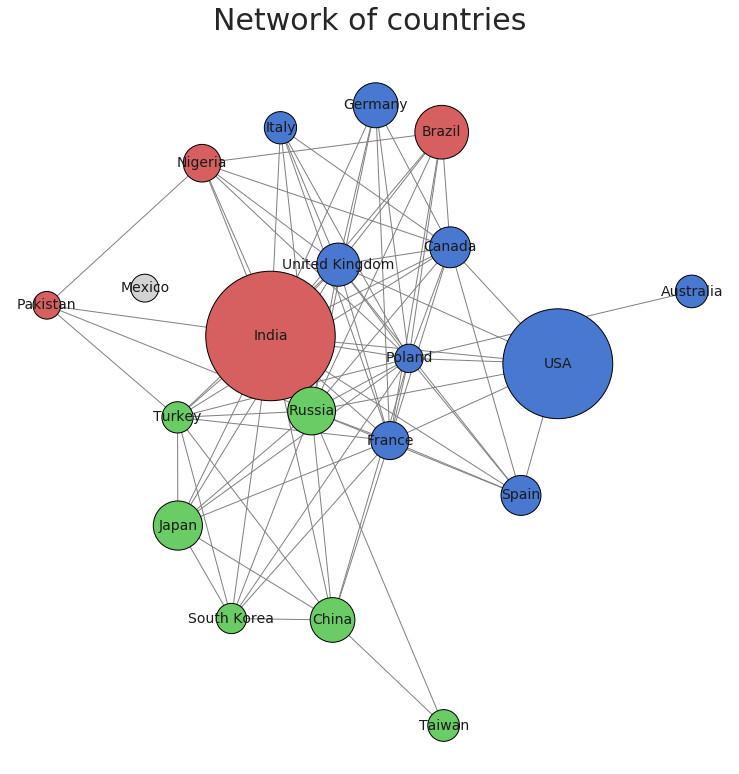

In [13]:
# Plotting the Graph
fig, ax = plt.subplots(figsize=(13, 13))
nx.draw(G, pos_kkl, node_size=list(pd.Series(countries_size)*5),
        edges=edges, width=weights, edge_color='grey', node_color=community_colors)
node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=14)

# Set the title
_ = ax.set_title('Network of countries', fontsize=30, pad=30)
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

The picture is stunningly surprising! Despite a popular globalized view on data science and AI as a field, the skill-based communities that are seen depict the existing cultural, economic, and geographical division: developing, western, and eastern countries. Interestingly, Japan and South Korea were categorized to eastern nations, albeit to a tangible extent resembling the USA in terms of IT advancement level. In turn, Turkey and Russia, although they were classified to the eastern alliance, are still close to the western cluster, which corresponds to the idea of geographical segregation in the area of AI. Mexico appeared to be beyond the erected categorization.

This piece of analysis tells us that cultural, economic, and geographical commonalities in their integrity determine the skill-based diversity in AI that exists in the world.

Concerning the amount of PhD graduates, from the graph below, we can notice a severe disproportion favoring western nations.

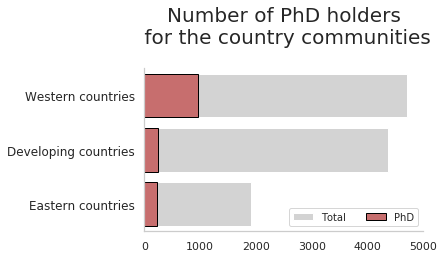

In [14]:
# Create dataframe with countries network statistics
country_network_stats = pd.DataFrame({'country':similarity_stats.columns,
                                      'community':partition})

# Drop Mexico
country_network_stats = country_network_stats[country_network_stats['community'] <= 2]
# Rename them
country_network_stats['community'] = country_network_stats['community'].map({0:'Western countries', 1:'Eastern countries', 2:'Developing countries'})
# Create dictionary with country and community
country_community_dict = dict(zip(country_network_stats['country'], country_network_stats['community']))

# Add countries community to dataframe with PhD participants
df_phd['country_community'] = [country_community_dict[country] if country in country_community_dict else np.nan for country in df_phd['Q3']]

# Add countries community to the full dataframe
df_fin['country_community'] = [country_community_dict[country] if country in country_community_dict else np.nan for country in df_fin['Q3']]

# Number of PhD in each country
stats_phd_total = pd.DataFrame({'PhD':df_phd['country_community'].value_counts(),
                                'Total':df_fin['country_community'].value_counts()})
stats_phd_total.reset_index(inplace=True)

sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x="Total", y="index", data=stats_phd_total,
            label="Total", color="lightgrey")
sns.barplot(x="PhD", y="index", data=stats_phd_total,
            label="PhD", color=COLORS_SET_B_G_R[2], edgecolor='black')
# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True, prop={'size': 10})
ax.set(xlim=(0, 5000), ylabel="", xlabel="PhD and Total")

# Remove reduntant borders and labels
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
sns.despine(left=False, bottom=False)

# Set title and labels size
_ = ax.set_title('Number of PhD holders\n for the country communities', fontsize=20, pad=25)
ax.tick_params(axis='y', which='major', labelsize=12)
_ = plt.setp(fig.patches, linewidth=0.5)

Now it begs the question: how do the individual- and global-level communities correspond to each other? The following heatmap is the answer.

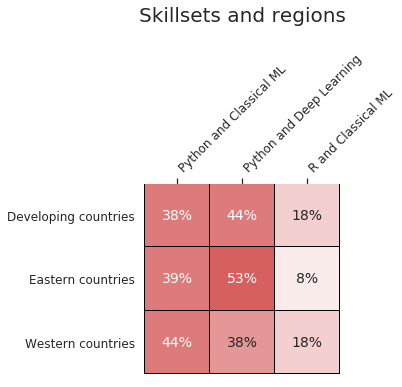

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.heatmap(pd.crosstab(df_phd['country_community'], df_phd['community'], normalize='index'),
            annot=True, fmt='.0%', linecolor ='black',linewidths=.01, cmap=ListedColormap(sns.light_palette(COLORS_SET_B_G_R[2]).as_hex()),
            cbar=False, annot_kws={"size": 14}, robust=True, vmin=0.05, vmax=0.55)

# Set title
ax.set_title('Eastern-Western difference')

# Set x ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.tick_top()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='left')

# Remove reduntant labels
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

# Set title
_ = ax.set_title('Skillsets and regions', fontsize=20, pad=30)

One vivid feature here is that Deep Learning professionals with PhD are concentrated to a significantly greater extent in Eastern cluster, than in the rest two. This is largely unexpected given that expertise in deep learning algorithms seems to be associated with a decent PhD training, which, for example, is offered by the top US universities. Such an observation might be explained by the so-called **leapfrog effect**: less advanced in terms of educational quality regions may adopt and proliferate the best practices sooner than their more developed counterparts due to radical rather than incremental innovations [4].

# <a>What are the Core and the Periphery Skills for Doctorates Overall and Across Regional Communities?</a>

At this point, let us dive deeper into the analysis of the skills network and look closer at its relational properties. You can check [this short illustrative story](http://matt.might.net/articles/phd-school-in-pictures/) before proceed.

The connection in the skill-based web below demonstrates the average proportion of Kaggle survey participants, possessing the respective pair of the attached skills. Large nodes symbolize a high (above average) share of professionals with PhD attainments within a given skill. 

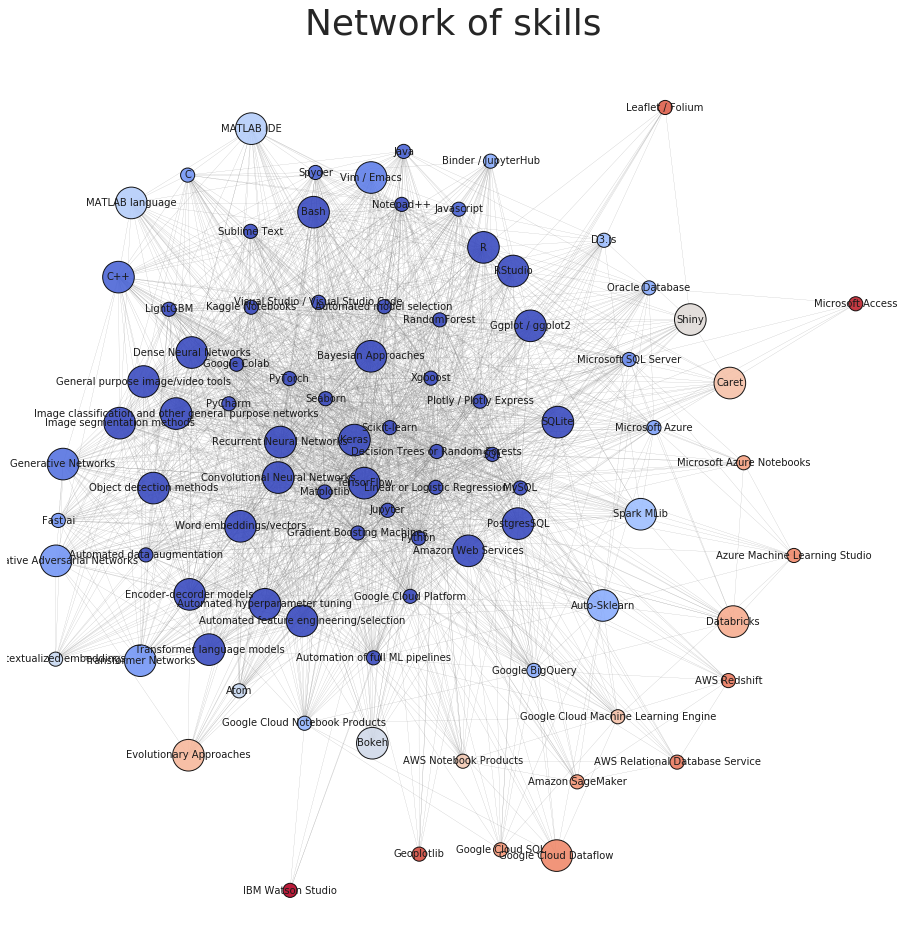

In [16]:
def createSkillsNetwork(df, countries=False):
    
    # Select subset of countries
    if countries:
        df = df[df['country_community'] == countries]
    
    # Creating similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS].T)
    np.fill_diagonal(similarity_matrix, 0)
    # Transform weighted network to binary via threshold
    threshold = np.median(similarity_matrix)
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    # Create Graph structure
    G = nx.from_numpy_matrix(similarity_matrix)
    G.remove_edges_from(nx.selfloop_edges(G))
    # Set weights for edges
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights = [w*0.25 for w in weights]
    # Set node sizes
    node_sizes = df.loc[:,SELECTED_SKILLS].sum().values / 10
    
    # Add labels
    labels = {}
    for i, label in enumerate(df.loc[:,SELECTED_SKILLS].columns):
        labels[i] = label
    # Total skills frequency
    total_skills_freq = df.loc[:,SELECTED_SKILLS].sum()
    # Proportion of PhDs per skill
    phd_skills_freq = df[df['Q4_phd'] == 'PhD'].loc[:,SELECTED_SKILLS].sum()
    phd_skills_proportion = phd_skills_freq / total_skills_freq
    # Proportion of PhD-students per skill
    phd_student_skills_freq = df.query("Q4_phd == 'PhD' and student == 'student'").loc[:,SELECTED_SKILLS].sum()
    phd_student_skills_proportion = phd_student_skills_freq / total_skills_freq

    # Create dataframe with skills statistics: avg. salary, core number, PhD proportion
    df_skills_stats = pd.DataFrame({'skill':SELECTED_SKILLS,
                                    'core_number':list(nx.algorithms.core.core_number(G).values()),
                                    'phd_proportion':phd_skills_proportion.values,
                                    'phd_student_proportion':phd_student_skills_proportion.values,
                                    'node_size':node_sizes})
    
    # Create binary version of phd proportion and core number
    df_skills_stats['core_bin'] = df_skills_stats['core_number'].apply(
        lambda x: 1 if x == max(df_skills_stats['core_number']) else 0)
    df_skills_stats['phd_bin'] = df_skills_stats['phd_proportion'].apply(
        lambda x: 1 if x >= np.mean(df_skills_stats['phd_proportion']) else 0)
    df_skills_stats['phd_student_bin'] = df_skills_stats['phd_student_proportion'].apply(
        lambda x: 1 if x >= np.mean(df_skills_stats['phd_student_proportion']) else 0)

    return G, labels, df_skills_stats

# Obtain skillsnetwork
G, labels, df_skills_stats = createSkillsNetwork(df_fin)

# Plot the Graph with PhD proportion
# Create kamada-kawai layout
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))
nx.draw(G, pos_kkl, node_size=list(map(lambda x: 1000 if x >= df_skills_stats['phd_proportion'].mean() else 200, list(df_skills_stats['phd_proportion']))), 
        width=0.15, edge_color='grey', node_color=list(df_skills_stats['core_number']), cmap="coolwarm_r", alpha=0.9)
node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=10)
# Set title
_ = ax.set_title('Network of skills', fontsize=36, pad=30)
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

We then computed **“coreness”** of each node – a parameter representing a skill’s closure to the core of the network. To learn more about k-core decomposition, look here [5]. The more bluish colors are indicative of a pronounced “coreness,” while the more reddish ones point on the network’s periphery. The picture enables to uncover an attractive finding: popular DL techniques and the respective software libraries *(Convolutional Neural Networks, Bayesian Approaches, Recurrent Neural Network, TensorFlow, Keras, etc.)* are widespread among the core PhD skills, whereas the periphery PhD skills seem to be rather specific, more academy-oriented, and in some sense constitute a more advanced DL expertise *(e.g., MATLAB, C++, Generative Adversarial Networks, Evolutionary Approaches, Generative Networks, Transformer Networks, etc.)*. This information, in a concise manner, also appears in the following wordclouds.

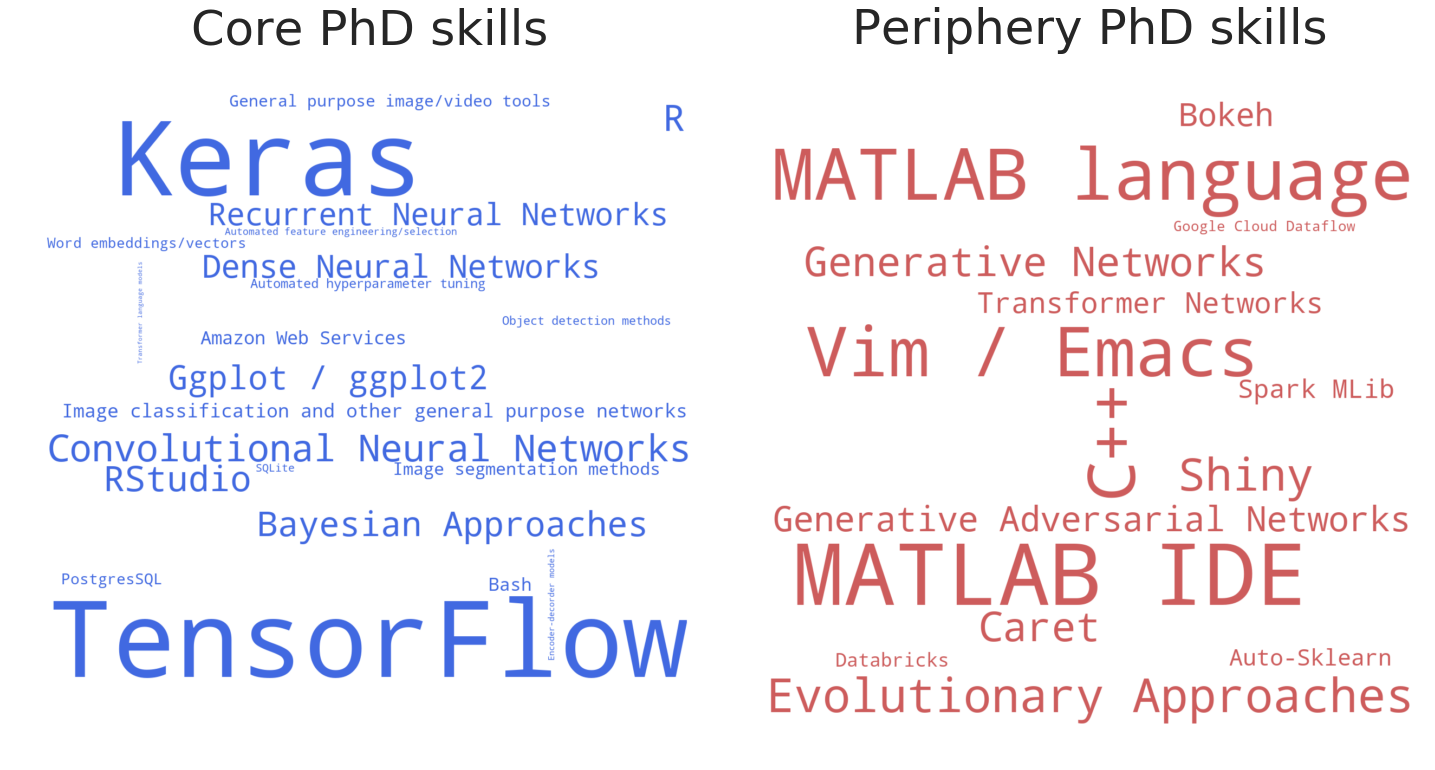

In [17]:
# Core PhD skills
core_phd_list = list(df_skills_stats.query("phd_bin == 1 and core_bin == 1").skill)
core_phd_list = df_fin.query("Q4 == 'Doctoral degree'").loc[:,core_phd_list].sum()

# Perephiery PhD skills
perephiery_phd_list = list(df_skills_stats.query("phd_bin == 1 and core_bin == 0").skill)
perephiery_phd_list = df_fin.query("Q4 == 'Doctoral degree'").loc[:,perephiery_phd_list].sum()

fig = plt.figure()
fig.set_size_inches(20, 10)
colors_set = ['royalblue', 'indianred']
skills_list = [core_phd_list,
               perephiery_phd_list]
titles_list = ['Core PhD skills', 'Periphery PhD skills']

for i in range(2):
    
    # Generate string with proportional words 
    top_skills = skills_list[i].sort_values(ascending=False)
    top_skills = top_skills.rank()
    skills_string = []
    for skill_i in range(len(top_skills)):
        skills_string.extend([top_skills.index[skill_i]] * int(top_skills.values[skill_i]))
    
    ax = fig.add_subplot(1,2,i+1)
    word_could_dict=Counter(skills_string)
    # Create wordcloud object
    wordcloud = WordCloud(width = 1200, height = 1200, background_color="white",
                          color_func=lambda *args, **kwargs: colors_set[i], relative_scaling = 0.5).generate_from_frequencies(word_could_dict)
    
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')
    # Set title
    ax.set_title(titles_list[i], size=48, pad=50)
    
plt.tight_layout(pad=0)
plt.show()

Overall, we figured out what the central and periphery competencies that describe a Kaggle PhD holder are. It would be intriguing to investigate national differences in the way this core-periphery continuum is manifested!

The following series of networks maps the coreness structure and the blocks of countries created earlier. Numbers in the titles of the respective graphs are correlation coefficients between the “coreness” of skills and the proportion of doctorates in them. 

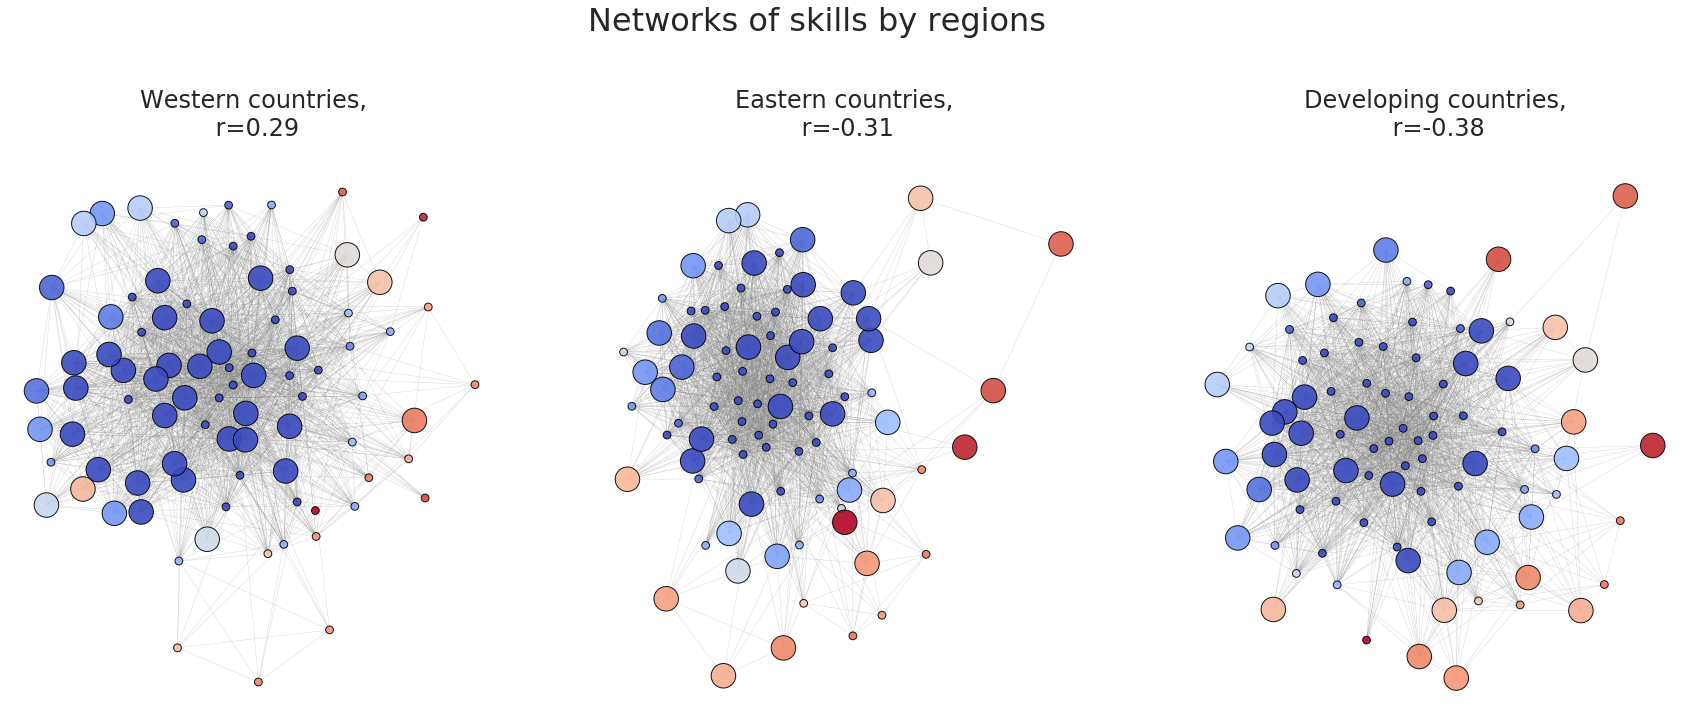

In [18]:
# Create grahs for each region
G_west, labels_west, df_skills_stats_west = createSkillsNetwork(df_fin, 'Western countries')
G_east, labels_east, df_skills_stats_east = createSkillsNetwork(df_fin, 'Eastern countries')
G_develop, labels_develop, df_skills_stats_develop = createSkillsNetwork(df_fin, 'Developing countries')

graphs = [G_west, G_east, G_develop]
df_skills_stats_list = [df_skills_stats_west, df_skills_stats_east, df_skills_stats_develop]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
ax = axes.flatten()
size_multip = 1

for i in range(3):
    # Create kamada-kawai layout
    pos_kkl = nx.kamada_kawai_layout(graphs[i])
    if i == 1:
        size_multip = 3
    # Draw network
    nx.draw_networkx(graphs[i], ax=ax[i], pos=pos_kkl,
                     node_size=list(map(lambda x: 600 if x >= df_skills_stats_list[i]['phd_proportion'].mean() else 60, list(df_skills_stats_list[i]['phd_proportion']))),
                     width=0.15,
                     edge_color='grey',node_color=list(df_skills_stats['core_number']), cmap="coolwarm_r", alpha=0.9,
                     with_labels=False)
    ax[i].set_axis_off()
    ax[i].collections[0].set_edgecolor("#000000")

# Set titles and correlation between coreness and PhD proportion
_ = axes[0].set_title('Western countries,\n r=0.29', fontsize=24, pad=30)
_ = axes[1].set_title('Eastern countries,\n r=-0.31', fontsize=24, pad=30)
_ = axes[2].set_title('Developing countries,\n r=-0.38', fontsize=24, pad=30)
# Set general title
st = fig.suptitle("Networks of skills by regions", fontsize=32, x =0.5, y=1.1)

plt.show()

The plots, as well as the numbers, inform us that PhD guys in Western countries prefer to concentrate on the core expertise. In contrast, AI professionals in Eastern and Developing regions are more periphery-oriented and, hence, selective in the scope of skills that they utilize. 

What does this tell us about? Perhaps, due to funding restrictions, PhD in Eastern and Developing countries tend to the less abounding but more advanced ML level with recent achievements. In contrast, wealthier Western nations can leave room for versatility. Again, this is in line with the **leapfrog effect**: a lack of (primarily) financial resources induces countries to follow the new standards more effectively but prohibiting from the less innovative practices.


# <a>Do People in the Data Science Field Earn More with a PhD Status?</a>

Our story has reached a much-anticipated topic. Assume you have decided to pursue PhD, what remuneration should you expect? Is it really worth it?

In [19]:
# Remove students from the dataframe
df_fin = df_fin[df_fin['Q5'] != 'Student']

# # Drop respondents who did't indicate their salary
df_fin = df_fin.dropna(subset=['Q10'])

# Change salary from interval to numeric scale
def transformSalary(string):
    if string == "> $500,000":
        mean_salary = 750000.
    else:
        mean_salary = np.round(np.mean([np.float(string.split('-')[0].replace('$', '').replace(',', '')),
                                        np.float(string.split('-')[1].replace(',', ''))]))
    return mean_salary
df_fin['Q10'] = df_fin['Q10'].apply(transformSalary)
df_fin['Q10'] = df_fin['Q10'].astype('float')

# Add binary variable USA-not USA
df_fin['Q3_USA'] = ['USA' if country == 'USA' else 'not USA' for country in df_fin['Q3']]

# Recode experience
exp_order = ['< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']
exp_level = ['Low experience', 'Low experience', 'Middle experience', 'Middle experience', 'High experience', 'High experience']
df_fin['Q15_level'] = df_fin['Q15'].map(dict(zip(exp_order, exp_level)))
df_fin['Q15_level'] = df_fin['Q15_level'].astype('category')
df_fin['Q15_level'].cat.reorder_categories(['Low experience', 'Middle experience', 'High experience'], inplace=True)

# Distribution of salary for PhD and distribution for Experience
df_fin_viz_phd_1 = df_fin.copy()
df_fin_viz_phd_1 = df_fin_viz_phd_1.query("Q4_phd != 'PhD'")

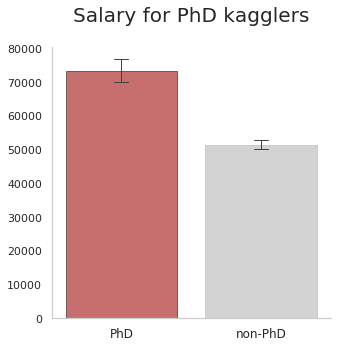

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
# First layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1, color='lightgrey',
                dodge=True, ci=None, capsize=0.1)

# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
# Set title
_ = ax.set_title('Salary for PhD kagglers', fontsize=20, pad=25)
# Set x ticks
ax.tick_params(axis='x', which='major', labelsize=12)
_ = ax.xaxis.set_ticklabels(["PhD", "non-PhD"])
_ = plt.setp(g.patches, linewidth=0.5) 

From this moment forward, we approximated one's wage as a middle value of the respective wage interval and also removed students from the sample. It looks like wages of PhD graduates outweigh those of non-PhD guys. But hold on! Let us drill further.

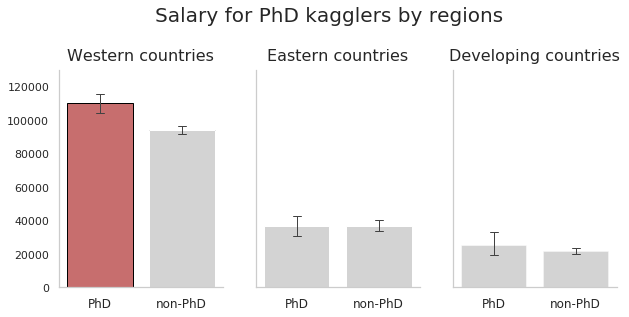

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
sns.set(font_scale=1, style="whitegrid")

# First layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin[df_fin['country_community'] == 'Western countries'], color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, ax=axes[0], errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1[df_fin_viz_phd_1['country_community'] == 'Western countries'], color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[0])
# Set y lim
_ = axes[0].set_ylim((0, 130000))
# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Western countries', fontsize=16, pad=10)
# Set x ticks params
axes[0].tick_params(axis='x', which='major', labelsize=12)
_ = axes[0].xaxis.set_ticklabels(["PhD", "non-PhD"])

g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin[df_fin['country_community'] == 'Eastern countries'], color='lightgrey',
                dodge=True, ci=90, capsize=0.1, ax=axes[1], errwidth =1)
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1[df_fin_viz_phd_1['country_community'] == 'Eastern countries'], color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[1])
# Set y limits
_ = axes[1].set_ylim((0, 130000))
# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
# Set title
_ = axes[1].set_title('Eastern countries', fontsize=16, pad=10)
# Set x ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)
axes[1].set_yticks([])
_ = axes[1].xaxis.set_ticklabels(["PhD", "non-PhD"])

# First layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin[df_fin['country_community'] == 'Developing countries'], color='lightgrey',
                dodge=True, ci=90, capsize=0.1, ax=axes[2], errwidth =1)
# Second layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1[df_fin_viz_phd_1['country_community'] == 'Developing countries'], color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[2])
# Set y lim
_ = axes[2].set_ylim((0, 130000))
# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
axes[2].xaxis.grid(False)
axes[2].yaxis.grid(False)
axes[2].xaxis.set_label_text("")
axes[2].yaxis.set_label_text("")
_ = axes[2].set_title('Developing countries', fontsize=16, pad=10)
axes[2].tick_params(axis='x', which='major', labelsize=12)
axes[2].set_yticks([])
_ = axes[2].xaxis.set_ticklabels(["PhD", "non-PhD"])

# Additional options
fig.subplots_adjust(wspace=0.2)
plt.setp(g.patches, linewidth=0.5) 

# Set general title
st = fig.suptitle("Salary for PhD kagglers by regions", fontsize=20, x =0.5, y=1.1)

The graph above shows that, sadly, the previous statement applies only to Western countries: earnings of PhD and non-PhD professionals in Eastern and Developing regions do not diverge statistically.

But we wouldn’t be us if we wouldn’t add a curious piece of complexity to the current analytical section: we accounted for the similarity in skillsets and experience levels in addition to the country-wise division. Concretely, we divided a labor market experience variable into the respective categories – low (less that 3 years of experience), middle (from 3 to 10 years), and high (more than 10 years) – and for each category computed a salary difference for PhD and non-PhD holders with a similar set of skills (cosine similarity was again leveraged here). 

The graph below is a visual representation of the conducted procedure. Positive and significant confidence intervals (excluding zero) favor guys with PhD (they get paid highlier), while negative and significant intervals – non-PhD specialists. Zero in a confidence interval means the difference is absent.

In [22]:
def salariesDifferencePhd(df, exp_level,  countries_community, q_threshold=0.95, SELECTED_SKILLS=SELECTED_SKILLS):
    '< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years'
    # Select subgroup of interest
    df = df.query("Q15_level == '{}' and country_community == '{}'".format(exp_level, countries_community))
        
    df.reset_index(inplace=True, drop=True)
    # Create similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS])
    threshold = np.quantile(np.concatenate(similarity_matrix), q_threshold)
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    np.fill_diagonal(similarity_matrix, 0)
    # Create dictionaries with index number and PhD status/Salary
    dict_index_phd = dict(zip(df.index, df['Q4_phd']))
    dict_index_salary = dict(zip(df.index, df['Q10']))
    # Transform adjency matrix to edge list
    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix.values[[np.arange(len(similarity_matrix))]*2] = np.nan
    edge_list = similarity_matrix.stack().reset_index()
    # Select only edges with high similarity
    edge_list = edge_list[edge_list[0] == 1]
    edge_list = edge_list.drop(columns=0)
    # Label status of participants
    edge_list['level_0_phd'] = edge_list['level_0'].apply(lambda x: dict_index_phd[x], 1)
    edge_list['level_1_phd'] = edge_list['level_1'].apply(lambda x: dict_index_phd[x], 1)
    # Select only PhD/not-PhD pairs
    edge_list = edge_list[edge_list.loc[:,['level_0_phd', 'level_1_phd']].apply(lambda nodes: True if nodes[0] != nodes[1] else False, 1)]
    # Get salaries of participants
    edge_list['level_0_salary'] = edge_list['level_0'].apply(lambda x: dict_index_salary[x], 1)
    edge_list['level_1_salary'] = edge_list['level_1'].apply(lambda x: dict_index_salary[x], 1)
    edge_list = edge_list[edge_list['level_0_phd'] == 'PhD']
    # Calculate salaries difference
    salary_diff = edge_list.groupby('level_0')['level_0_salary'].mean() - edge_list.groupby('level_0')['level_1_salary'].mean()
    # Resulting dataframe
    result_df = pd.DataFrame({'Salary difference':salary_diff,
                'Experience level':len(salary_diff) * [exp_level],
                'Countries':len(salary_diff) * [countries_community]}).reset_index(drop=True)
    return result_df

# Calculate salary diff
salary_diff_df = pd.DataFrame()
for exp in ['Low experience', 'Middle experience', 'High experience']:
    for countries in ['Western countries', 'Eastern countries', 'Developing countries']:       
        salary_diff_df = salary_diff_df.append(salariesDifferencePhd(df_fin, exp, countries))
salary_diff_df.reset_index(inplace=True, drop=True)

# Order experience level for visualization
salary_diff_df['Experience level'] = salary_diff_df['Experience level'].astype('category')
salary_diff_df['Experience level'].cat.reorder_categories(['Low experience', 'Middle experience', 'High experience'], inplace=True)

# Create dataframes for visualization
salary_diff_df_viz_1 = salary_diff_df[salary_diff_df['Countries'] == 'Western countries'].copy()
salary_diff_df_viz_1 = salary_diff_df_viz_1[salary_diff_df_viz_1['Experience level'] != 'Low experience']

salary_diff_df_viz_2 = salary_diff_df[salary_diff_df['Countries'] == 'Eastern countries'].copy()
salary_diff_df_viz_2 = salary_diff_df_viz_2[salary_diff_df_viz_2['Experience level'] != 'Low experience']

salary_diff_df_viz_3 = salary_diff_df[salary_diff_df['Countries'] == 'Developing countries'].copy()
salary_diff_df_viz_3 = salary_diff_df_viz_3[salary_diff_df_viz_3['Experience level'] != 'High experience']

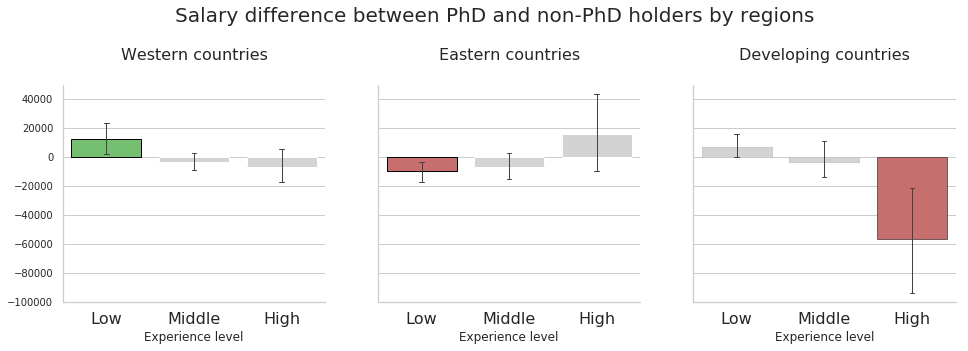

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
sns.set(font_scale=1, style="whitegrid")

### FIRST GRAPH
# Plot first layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df[salary_diff_df['Countries'] == 'Western countries'],
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[1], ax=axes[0], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df_viz_1,
                dodge=True, errwidth =2, ci=None, capsize=.05, color='lightgrey', ax=axes[0])
# Set y limit
_ = axes[0].set_ylim((-100000,50000))
# Remove redundant borderes
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Western countries', fontsize=16, pad=25)
# Set x and y ticks
axes[0].tick_params(axis='y', which='major', labelsize=10)
axes[0].tick_params(axis='x', which='major', labelsize=16)
axes[0].xaxis.set_ticklabels(["Low", "Middle", "High"])

### SECOND GRAPH
# Plot first layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df[salary_diff_df['Countries'] == 'Eastern countries'],
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[1], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df_viz_2,
                dodge=True, errwidth =2, ci=None, capsize=.05, color='lightgrey', ax=axes[1])
# Set y limit
_ = axes[1].set_ylim((-100000,50000))
# Remove redundant borderes
sns.despine(left=False, bottom=False)
axes[1].xaxis.grid(False)
axes[1].yaxis.set_label_text("")
# Set title
_ = axes[1].set_title('Eastern countries', fontsize=16, pad=25)
# Set x and y ticks
axes[1].tick_params(axis='y', which='major', labelsize=10)
axes[1].tick_params(axis='x', which='major', labelsize=16)
axes[1].yaxis.set_ticklabels([])
axes[1].xaxis.set_ticklabels(["Low", "Middle", "High"])

### THIRD GRAPH
# Plot first layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df[salary_diff_df['Countries'] == 'Developing countries'],
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[2], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df_viz_3,
                dodge=True, errwidth =2, ci=None, capsize=.05, color='lightgrey', ax=axes[2])
# Set y limit
_ = axes[2].set_ylim((-100000,50000))
# Remove redundant borderes
sns.despine(left=False, bottom=False)
axes[2].xaxis.grid(False)
axes[2].yaxis.set_label_text("")
# Set title
_ = axes[2].set_title('Developing countries', fontsize=16, pad=25)
# Set x and y ticks
axes[2].tick_params(axis='y', which='major', labelsize=10)
axes[2].tick_params(axis='x', which='major', labelsize=16)
_ = axes[2].yaxis.set_ticklabels([])
axes[2].xaxis.set_ticklabels(["Low", "Middle", "High"])

# Additional options
plt.setp(g.patches, linewidth=0.5)

# Set general title
st = fig.suptitle("Salary difference between PhD and non-PhD holders by regions", fontsize=20, x =0.5, y=1.15)

What can be noticed? If we account for the skill similarity, the three interesting observations are as follows:

* Western countries: only low-experienced doctorates “win the race”.
* Eastern countries: low-experienced PhD specialists are evaluated lower in terms of money.
* Developing countries: these are high-experienced PhD professionals whose remuneration substantially lags behind their non-academic counterparts.

What does that mean? For Western countries, it means that PhD seems to work only as a **“signal”** paving the way for better-paid jobs at the beginning of one’s career. As the level of experience rises, non-PhD people can catch up using achievements that are thanks to their experience. Doctoral degree in the East does not seem to work even as a signal. In Developing countries, the situation is alarming: PhD status can significantly downgrade your salary later on as you gain more experience in the area.


# <a>Does Gender Discrimination Also Apply to Women with a PhD Degree?</a>

We are all aware of the fact that women are discriminated against in the labor market, and occupations in the field of AI are not an exception. How does this situation look like amongst PhD holders?

We did the same computational trick for gender as for PhD vs. non-PhD kagglers in the previous section: we calculated a wage difference (absolute and normed by a mean salary in the region) for men and women with similar skillsets by country communities and only for PhD holders. The results are depicted by the graphs below.


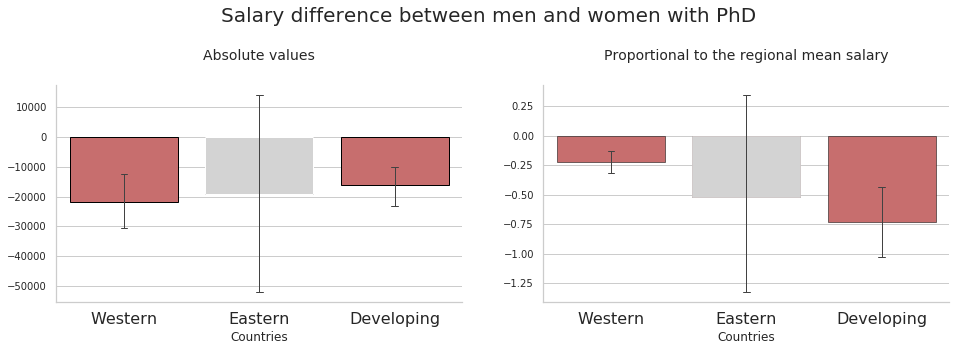

In [24]:
def salariesDifferenceGender(df, countries_community, q_threshold=0.95,
                             SELECTED_SKILLS=SELECTED_SKILLS, only_phd=True):
    
    # Select only male and female respondents
    df = df.query("Q2 == 'Male' or Q2 == 'Female'")
    
    # Select subgroup of interest
    df = df.query("country_community == '{}'".format(countries_community))
    
    if only_phd:
        df = df.query("Q4 == 'Doctoral degree'")
        
    df.reset_index(inplace=True, drop=True)
    # Create similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS])
    threshold = np.quantile(np.concatenate(similarity_matrix), q_threshold)
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    np.fill_diagonal(similarity_matrix, 0)
    # Create dictionaries with index number and PhD status/Salary
    dict_index_phd = dict(zip(df.index, df['Q2']))
    dict_index_salary = dict(zip(df.index, df['Q10']))
    # Transform adjency matrix to edge list
    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix.values[[np.arange(len(similarity_matrix))]*2] = np.nan
    edge_list = similarity_matrix.stack().reset_index()
    # Select only edges with high similarity
    edge_list = edge_list[edge_list[0] == 1]
    edge_list = edge_list.drop(columns=0)
    # Label status of participants
    edge_list['level_0_phd'] = edge_list['level_0'].apply(lambda x: dict_index_phd[x], 1)
    edge_list['level_1_phd'] = edge_list['level_1'].apply(lambda x: dict_index_phd[x], 1)
    # Select only PhD/not-PhD pairs
    edge_list = edge_list[edge_list.loc[:,['level_0_phd', 'level_1_phd']].apply(lambda nodes: True if nodes[0] != nodes[1] else False, 1)]
    # Get salaries of participants
    edge_list['level_0_salary'] = edge_list['level_0'].apply(lambda x: dict_index_salary[x], 1)
    edge_list['level_1_salary'] = edge_list['level_1'].apply(lambda x: dict_index_salary[x], 1)
    edge_list = edge_list[edge_list['level_0_phd'] == 'Female']
    
    # Calculate salaries difference
    salary_diff = edge_list.groupby('level_0')['level_0_salary'].mean() - edge_list.groupby('level_0')['level_1_salary'].mean()

    # Resulting dataframe
    if only_phd:
        result_df = pd.DataFrame({'Salary difference':salary_diff,
                                  'Countries':len(salary_diff) * [countries_community],
                                  'Subset':len(salary_diff) * ['PhD']}).reset_index(drop=True)
    else:
        result_df = pd.DataFrame({'Salary difference':salary_diff,
                          'Countries':len(salary_diff) * [countries_community],
                          'Subset':len(salary_diff) * ['Total']}).reset_index(drop=True)
    
    return result_df

salary_diff_df_gender = pd.DataFrame()
for countries in ['Western countries', 'Eastern countries', 'Developing countries']:       
    salary_diff_df_gender = salary_diff_df_gender.append(salariesDifferenceGender(df_fin, countries, q_threshold=0.95))
salary_diff_df_gender.reset_index(inplace=True, drop=True)

# Take only PhD differences
salary_diff_df_gender_phd = salary_diff_df_gender[salary_diff_df_gender['Subset'] == 'PhD']

# Obtain mean salary for each region
dict_country_salary = {'Western countries':np.mean(df_fin[df_fin['country_community'] == 'Western countries']['Q10']),
                       'Eastern countries':np.mean(df_fin[df_fin['country_community'] == 'Eastern countries']['Q10']),
                       'Developing countries':np.mean(df_fin[df_fin['country_community'] == 'Developing countries']['Q10'])}
salary_diff_df_gender_phd['Mean salary'] = salary_diff_df_gender_phd['Countries'].map(dict_country_salary)
# Calculate proportional difference
salary_diff_df_gender_phd['Salary difference, proportional to the regional mean salary'] = salary_diff_df_gender_phd['Salary difference'] / salary_diff_df_gender_phd['Mean salary']

# Order countries for plot
salary_diff_df_gender_phd['Countries'] = salary_diff_df_gender_phd['Countries'].astype('category')
salary_diff_df_gender_phd['Countries'].cat.reorder_categories(["Western countries", "Eastern countries", "Developing countries"], inplace=True)

# Create dataframe for visualization
salary_diff_df_gender_phd_viz = salary_diff_df_gender_phd.copy()
salary_diff_df_gender_phd_viz = salary_diff_df_gender_phd_viz[salary_diff_df_gender_phd_viz['Countries'] == 'Eastern countries']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.set(font_scale=1, style="whitegrid")
# Plot first layer
g = sns.barplot(x="Countries", y="Salary difference", data=salary_diff_df_gender_phd,
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[0], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Countries", y="Salary difference", data=salary_diff_df_gender_phd_viz,
                dodge=True, errwidth =1, ci=None, capsize=.05, color='lightgrey', ax=axes[0])
# Remove redundant borders
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Absolute values', fontsize=14, pad=25)
# Set ticks
axes[0].tick_params(axis='y', which='major', labelsize=10)
axes[0].tick_params(axis='x', which='major', labelsize=16)
_ = axes[0].xaxis.set_ticklabels(["Western", "Eastern", "Developing"])

# Plot first layer
g = sns.barplot(x="Countries", y="Salary difference, proportional to the regional mean salary", data=salary_diff_df_gender_phd,
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[1], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Countries", y="Salary difference, proportional to the regional mean salary", data=salary_diff_df_gender_phd_viz,
                dodge=True, errwidth =1, ci=None, capsize=.05, color='lightgrey', ax=axes[1])
# Remove redundant borders
sns.despine(left=False, bottom=False)
axes[1].xaxis.grid(False)
axes[1].yaxis.set_label_text("")
# Set title
_ = axes[1].set_title('Proportional to the regional mean salary', fontsize=14, pad=25)
# Set ticks
axes[1].tick_params(axis='y', which='major', labelsize=10)
axes[1].tick_params(axis='x', which='major', labelsize=16)
_ = axes[1].xaxis.set_ticklabels(["Western", "Eastern", "Developing"])

# Additional options
_ = plt.setp(g.patches, linewidth=0.5) 

# Set general title
st = fig.suptitle('Salary difference between men and women with PhD', fontsize=20, x =0.5, y=1.15)

A remarkable finding is that discrimination of females exists in Western and Developing countries, while in the East women do not seem to be discriminated: the respective wage difference is not statistically significant (straddle zero). In absolute numbers, Western nations might look like the most discriminated, but that is because, on average, people there are paid higher. Therefore, relative figures are more informative, and they suggest that the most pronounced underestimation of PhD women with regard to their earnings happens in the Developing World.

# <a>Conclusions</a>

In a nutshell, our mini-study attempted to explore an array of questions associated with PhD kagglers. We were striving to conduct a holistic analytical work with attractive methodological solutions that would deepen our knowledge about socially important issues related to our group of interest. Overall, the critical findings that we found are as follows.

1. There are 3 consistent skillset types that characterize data analysts with a doctoral degree: **R and Classical ML, Python and Classical ML,** and **Python and Deep Learning**. PhD guys that belong to Python and Classical ML category are vulnerable to a **skillset erosion**, meaning that the competencies they have are less delineated and unique compared to the ones possessed by doctorates from other clusters. Likewise, PhD students and low-experienced doctorates displayed more blurred boundaries in their skillsets.
 
2. Cultural, economic, and geographical commonalities in their integrity determine the skill-based diversity in AI that exists in the world. Ph.D. holders are disproportionally concentrated in the West compared to other regions. Python and Deep Learning community is attributable to a greater extent to Eastern countries, which can be explained by the **leapfrog effect**, or the tendency to adopt the best practices due to the power of disrupting innovations.

3. Western nations embrace the core PhD skills, i.e., diverse ML techniques, while Eastern and Developing nations are more periphery-oriented in terms of skills, i.e., embrace less abounding but more advanced ML techniques.

4. In the West, PhD status works as a **signal** helping low-experienced employees get a better-paid job, whereas, in other regions, it does not. Having a PhD level is redundant with regard to wages for middle- and higher-experienced workers. Besides, developing countries are in a dangerous position: PhD for a top data science experience may even deteriorate one's skills value and lead to lower earnings.

5. Doctoral women in Developing countries seem to be discriminated against the most. A sizable level of discrimination is also present in the West, while Eastern countries appeared to be more egalitarian regarding women's salaries in the labor market.


We hope that our story was enjoyable to a reader and helped unveil several curious insights about PhD kagglers and their skillsets. Furthermore, we sincerely hope to attract people’s attention to the troubles that doctorates might go through. Notably, geographical and economic segregation in the data science skills is still strong: we need to dissolve those regional borders to make knowledge in data science unconditional to the national barriers. 

Moreover, no doubt, academic aspirations should be widely encouraged everywhere since favorable social payoffs from that are indisputable. However, a fly in the ointment is that these days, the answer to the question **“Is PhD really worth it?”** seems to be heavily susceptible to gender and regional peculiarities. Governments and policy leaders should put more effort into ensuring a sufficient level of equality and financial support to AI professionals who strive for PhD, especially to the discriminated groups. This is how the status of data science as **“the sexiest job of the 21st century”** can be retained in the long run!

# <a>References</a>
1.	Cyranoski, D., Gilbert, N., Ledford, H., Nayar, A., & Yahia, M. (2011). Education: the PhD factory. Nature news, 472(7343), 276-279.
2.	Gaeta, G. L. (2015). Was it worth it? An empirical analysis of over-education among PhD recipients in Italy. International Journal of Social Economics, 42(3), 222-238.
3.	Leimeister, J. M., Becker, J., Heinzl, A., Winter, R., & Gefen, D. (2019). Doing a Doctorate in BISE in Germany, Austria and Switzerland? A Debate on the Why, What and How. Business & Information Systems Engineering, 61(6), 759-766.
4.	Wikipedia, https://en.wikipedia.org/wiki/Leapfrogging
5.	Giatsidis, C., Malliaros, F. D., Tziortziotis, N., Dhanjal, C., Kiagias, E., Thilikos, D. M., & Vazirgiannis, M. (2016). A k-core decomposition framework for graph clustering.
